In [1]:
import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [3]:
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [4]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [7]:
len(chunks)

123

In [8]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: contracts, products, company, employees


In [9]:
embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [10]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 1,536 dimensions


In [11]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

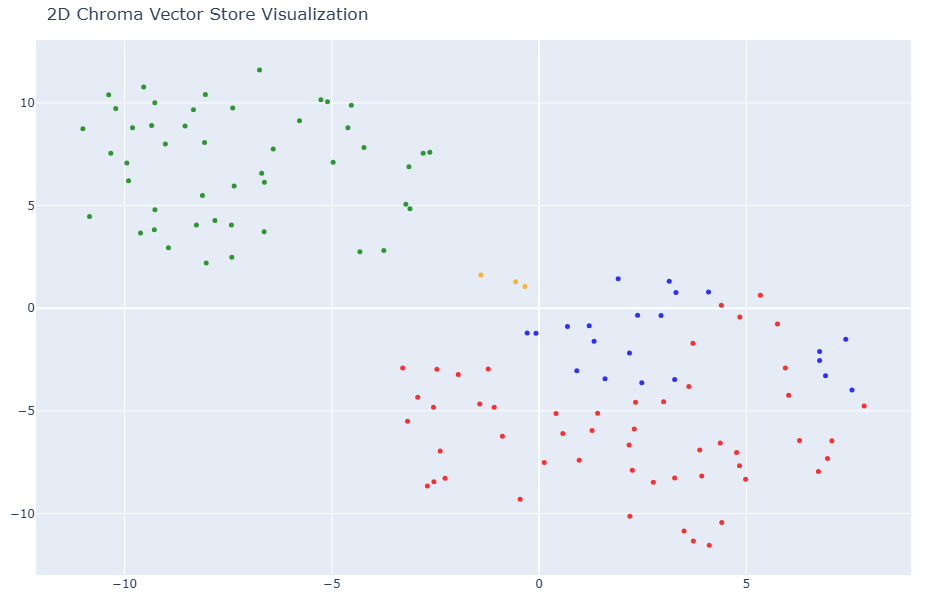

In [12]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

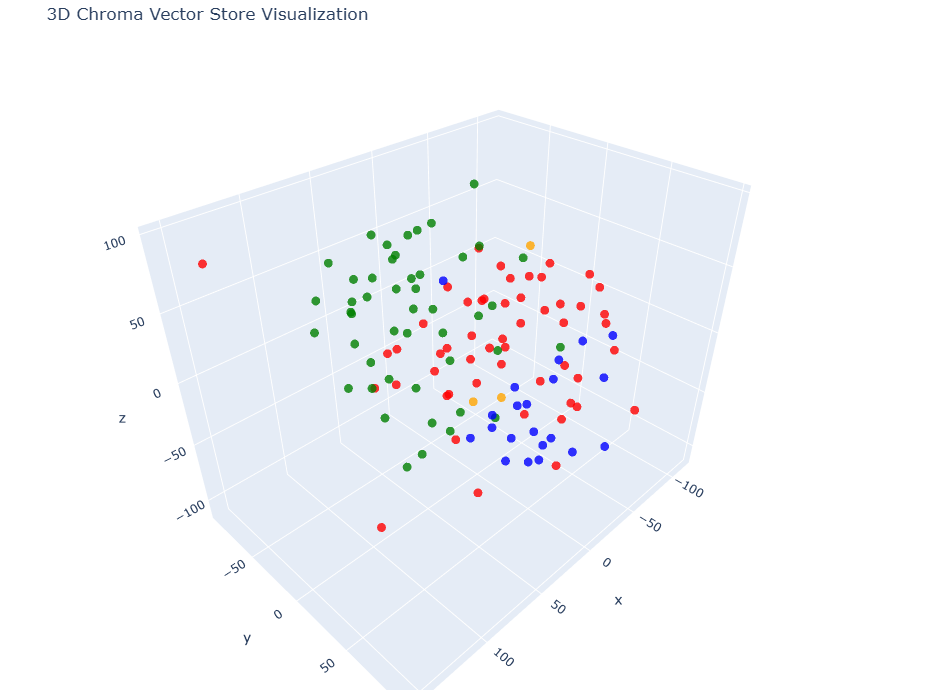

In [13]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [19]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.5, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [20]:
query = "Can you describe Insurellm in a few sentences"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Insurellm is an innovative insurance tech startup founded by Avery Lancaster in 2015, designed to disrupt the insurance industry with cutting-edge products. It offers four software solutions: Carllm for auto insurance, Homellm for home insurance, Rellm for reinsurance, and Marketllm, a marketplace connecting consumers with insurance providers. With 200 employees and over 300 clients worldwide, Insurellm aims to transform the insurance landscape through technology and innovation.


In [21]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [22]:
def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [23]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [1]:
import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
!pip install faiss-cpu

   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
   ---------------- ----------------------- 7.6/18.2 MB 39.3 MB/s eta 0:00:01
   ------------------------------------- -- 17.0/18.2 MB 42.9 MB/s eta 0:00:01
   ---------------------------------------- 18.2/18.2 MB 38.2 MB/s  0:00:00


In [3]:

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
# from langchain_chroma import Chroma
from langchain.vectorstores import FAISS
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [4]:
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [5]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [8]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [9]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [10]:
len(chunks)

123

In [11]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: contracts, employees, company, products


In [12]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()

# Create vectorstore

# BEFORE
# vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)

# AFTER
vectorstore = FAISS.from_documents(chunks, embedding=embeddings)

total_vectors = vectorstore.index.ntotal
dimensions = vectorstore.index.d

print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 1,536 dimensions in the vector store


In [13]:
# Prework
vectors = []
documents = []
doc_types = []
colors = []
color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

for i in range(total_vectors):
    vectors.append(vectorstore.index.reconstruct(i))
    doc_id = vectorstore.index_to_docstore_id[i]
    document = vectorstore.docstore.search(doc_id)
    documents.append(document.page_content)
    doc_type = document.metadata['doc_type']
    doc_types.append(doc_type)
    colors.append(color_map[doc_type])
    
vectors = np.array(vectors)

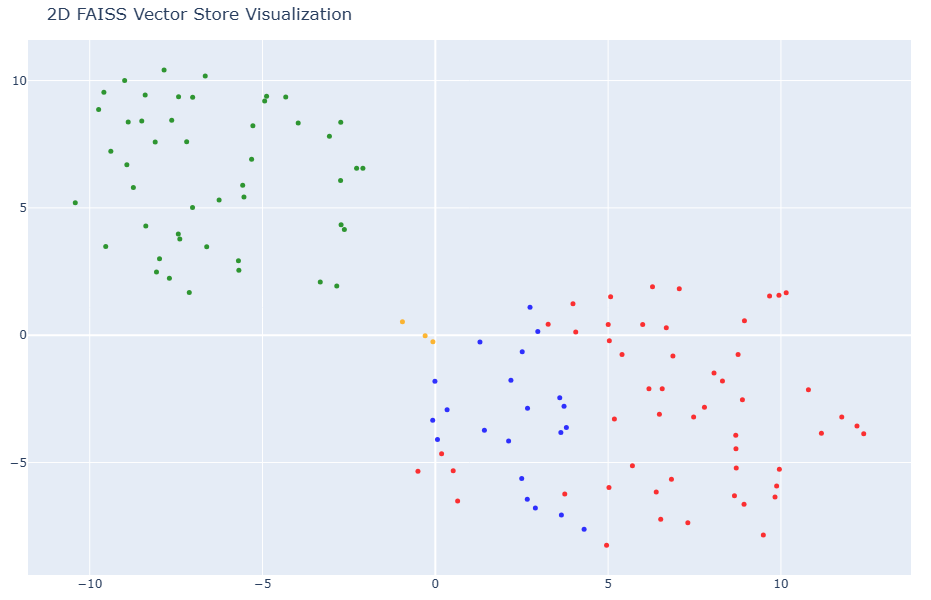

In [14]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

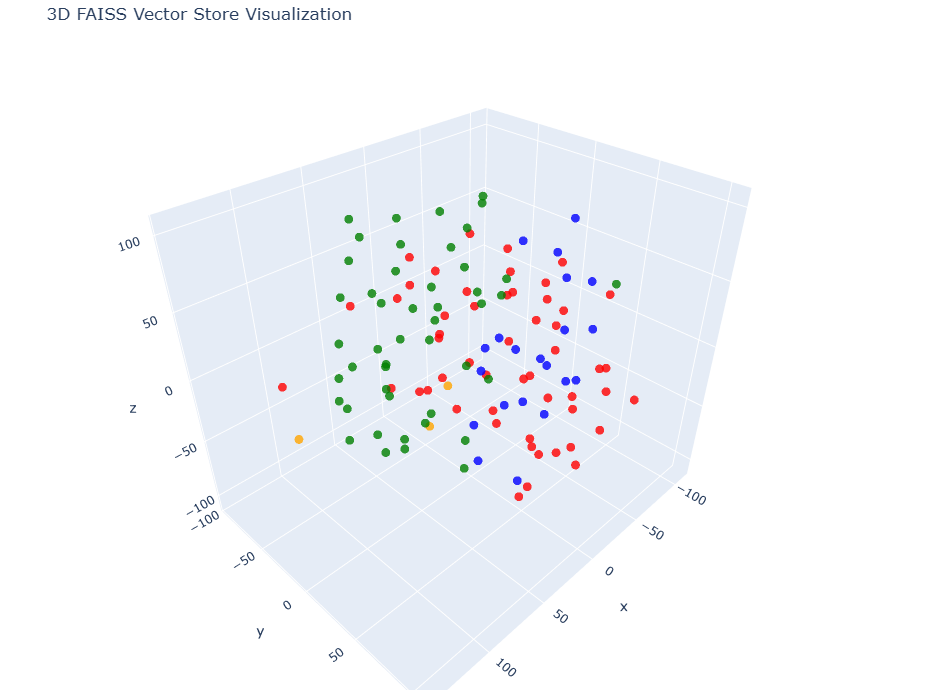

In [15]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [16]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

C:\Users\hp\AppData\Local\Temp\ipykernel_1228\4268784041.py:5: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



In [17]:
query = "Can you describe Insurellm in a few sentences"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Insurellm is an innovative insurance tech startup founded by Avery Lancaster in 2015, aimed at disrupting the insurance industry with cutting-edge products. With 200 employees and 12 offices across the US, Insurellm offers four main software products: Carllm for auto insurance, Homellm for home insurance, Rellm for the reinsurance sector, and Marketllm, a marketplace connecting consumers with insurance providers. The company serves over 300 clients worldwide, focusing on transforming the insurance landscape through technology and innovation.


In [18]:
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [19]:
# Wrapping that in a function

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [20]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
